In [5]:
%tensorflow_version 1.x

#Import

In [22]:
import os, os.path
from subprocess import getoutput
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import cv2
#Data visualization
import seaborn as sns
from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import time
import math

from collections import Counter
from collections import defaultdict
from collections import OrderedDict

from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Parametri modello 1 64x512

In [23]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [24]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 99 (delta 9), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (99/99), done.


In [25]:
import Defining_Methods as my_lib

In [26]:
def get_dataset_crop(db, _batch_size, _dim1, _dim2, drive):

  if db == '9k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"1nderD97u_2d1I6TE3ey8wBtEWqLAosk4"})
    downloaded.GetContentFile('data_9400_88.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data_9400_88.zip -d DB_Repo/
    getoutput("unzip -q data_9400_88.zip -d DB_Repo/")

  elif db == '14k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"1z5J7XE_KJYzZGJd-NHX8PUggED2ZK8HG"})
    downloaded.GetContentFile('data.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data.zip -d DB_Repo/
    getoutput("unzip -q data.zip -d DB_Repo/")

  elif db == '18k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})
    downloaded.GetContentFile('data_18800.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data_18800.zip -d DB_Repo/
    getoutput("unzip -q data_18800.zip -d DB_Repo/")

  elif db == '37k':
    #%cd /content
    os.chdir("/content")
    downloaded = drive.CreateFile({'id':"1s5Z92N0_UqIsI1xoQewsFmhs2iDGk14F"})
    downloaded.GetContentFile('data_37600.zip')
    #!rm -rf DB_Repo
    getoutput("rm -rf DB_Repo")
    #!unzip -q data_18800.zip -d DB_Repo/
    getoutput("unzip -q data_37600.zip -d DB_Repo/")

  else:
    raise ValueError("Keyword for database not recognized; use '9k', '14k' or '18k'.")
  
  path, dirs, files = next(os.walk("/content/DB_Repo/data"))
  file_count = len(files)
  print(file_count)
  #%cd /content/DB_Repo/data
  os.chdir("/content/DB_Repo/data")

  ##PARAMETERS

  dim1 = _dim1
  dim2 = _dim2

  total_pixels = dim1 * dim2
  MAX_LEN = 64 #fisso

  #Considero il primo 20% della lista di dati come test set
  test_percentage = 20 #%
  #Considero il 20% della lista di dati - esclusi i dati di test - come validation set
  validation_percentage = 20 #%

  #COSTANTI E DICHIARAZIONI

  database_list = list()
  labels_list = list()
  obf_list = list()

  #LETTURA E RESIZE IMMAGINI

  print("START IMAGE INPUT")
  #Aggiungo i valori alle liste leggendo i vari files
  for filename in glob.glob('*.npy'):
    temp_img = np.load(filename)
    temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.uint16)
    #flattening
    temp_img = temp_img.flatten()
    dimensione = temp_img.size

    #padding fino alla dimensione dim1xdim2
    #o crop fino a dim1xdim2 pixels
    if dimensione < total_pixels:
      temp_img = np.pad(temp_img, (0, total_pixels - dimensione), mode='constant',constant_values=0)
    elif dimensione >= total_pixels:
      temp_img = temp_img[0:total_pixels]
    else:
      raise ValueError("Error in reading images.")

    temp_img = temp_img.reshape((dim1, dim2))
    database_list.append(temp_img)
    #Salvo la label, ossia la classe
    labels_list.append(my_lib.extract_label(filename))
    #Salvo la lista di offuscatori di ogni file
    obf_list.append(my_lib.extract_obf(filename))
  print("END IMAGE INPUT")

  #SHUFFLE

  #Ho i valori e le etichette in due liste (+ obf); 
  #le mescolo mantenendo l'ordine tra valore-label
  temp = list(zip(database_list, labels_list, obf_list))
  np.random.shuffle(temp)
  database_list, labels_list, obf_list = zip(*temp)

  #SUDDIVISIONE DATI
  #Suddivido in training set, test set e validation test
  assert len(database_list) == len(labels_list) == len(obf_list)
  #print(len(database_list))

  #Split per creare test set
  index_to_split = math.ceil((len(database_list) * test_percentage) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

  test_list, training_list = [database_list[s:e+1] for s,e in indices]
  labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
  obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

  #Split per creare validation set
  index_to_split = math.ceil((len(training_list) * validation_percentage) / 100)
  indices = [(0, index_to_split - 1), (index_to_split, len(training_list) - 1)]

  validation_list, training_list = [training_list[s:e+1] for s,e in indices]
  labels_validation_list, labels_training_list = [labels_training_list[s:e+1] for s,e in indices]
  obf_validation_list, obf_training_list = [obf_training_list[s:e+1] for s,e in indices]

  #Trasformo i valori in numpy.ndarray
  train_images = np.array(training_list)
  test_images = np.array(test_list)
  validation_images = np.array(validation_list)

  train_labels = np.array(labels_training_list)
  test_labels = np.array(labels_test_list)
  validation_labels = np.array(labels_validation_list)

  train_obf = np.array(obf_training_list)
  test_obf = np.array(obf_test_list)
  validation_obf = np.array(obf_validation_list)

  #Encoding delle labels;
  #Se nella suddivisione il 100% di una classe è fuori dal train_labels,
  #Vi sarà un errore nell'encoding delle labels negli altri set.
  label_encoder = LabelEncoder()
  label_encoder.fit(train_labels)
  train_labels_encoded = label_encoder.transform(train_labels)
  test_labels_encoded = label_encoder.transform(test_labels)
  validation_labels_encoded = label_encoder.transform(validation_labels)

  #Normalizzazione valori in range 0-1
  train_images = train_images / 65535.0
  test_images = test_images / 65535.0
  validation_images = validation_images / 65535.0

  #Dichiarazione altri parametri
  n_classes = len(list(label_encoder.classes_))

  sets_and_labels = (train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded)
  numpy_arrays = (train_obf, test_obf, validation_obf)
  return sets_and_labels, numpy_arrays, label_encoder, n_classes

In [29]:
database_scelto = '37k' #or '14k' or '9k'

dim1 = 64
dim2 = 128
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 150
patience = 10

In [30]:
sets_and_labels, numpy_arrays, label_encoder, n_classes = get_dataset_crop(database_scelto, batch_size, dim1, dim2, drive)

train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
_, _, validation_obf = numpy_arrays

37600
START IMAGE INPUT
END IMAGE INPUT


In [31]:
sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

In [32]:
print(len(train_images))
print(len(test_images))
print(len(validation_images))

24064
7520
6016


##Modello 1

In [33]:
modelLSTM, hist, time_callback = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Risultati modello 1

In [34]:
number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)
print("Total epochs", number_of_epochs_it_ran)
print(str(total_time), "s")

6016/6016 [==============================] - 4s 677us/sample - loss: 0.3063 - acc: 0.9441
Total epochs 91
701.2568869590759 s


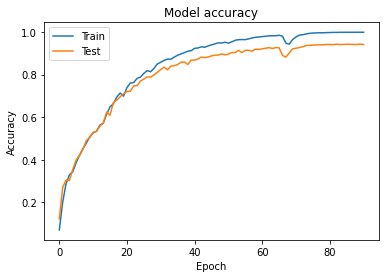

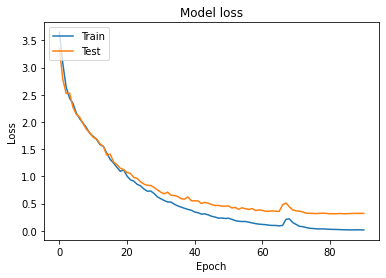

In [35]:
plt.show(my_lib.plot_model_acc(hist))
plt.show(my_lib.plot_model_loss(hist))

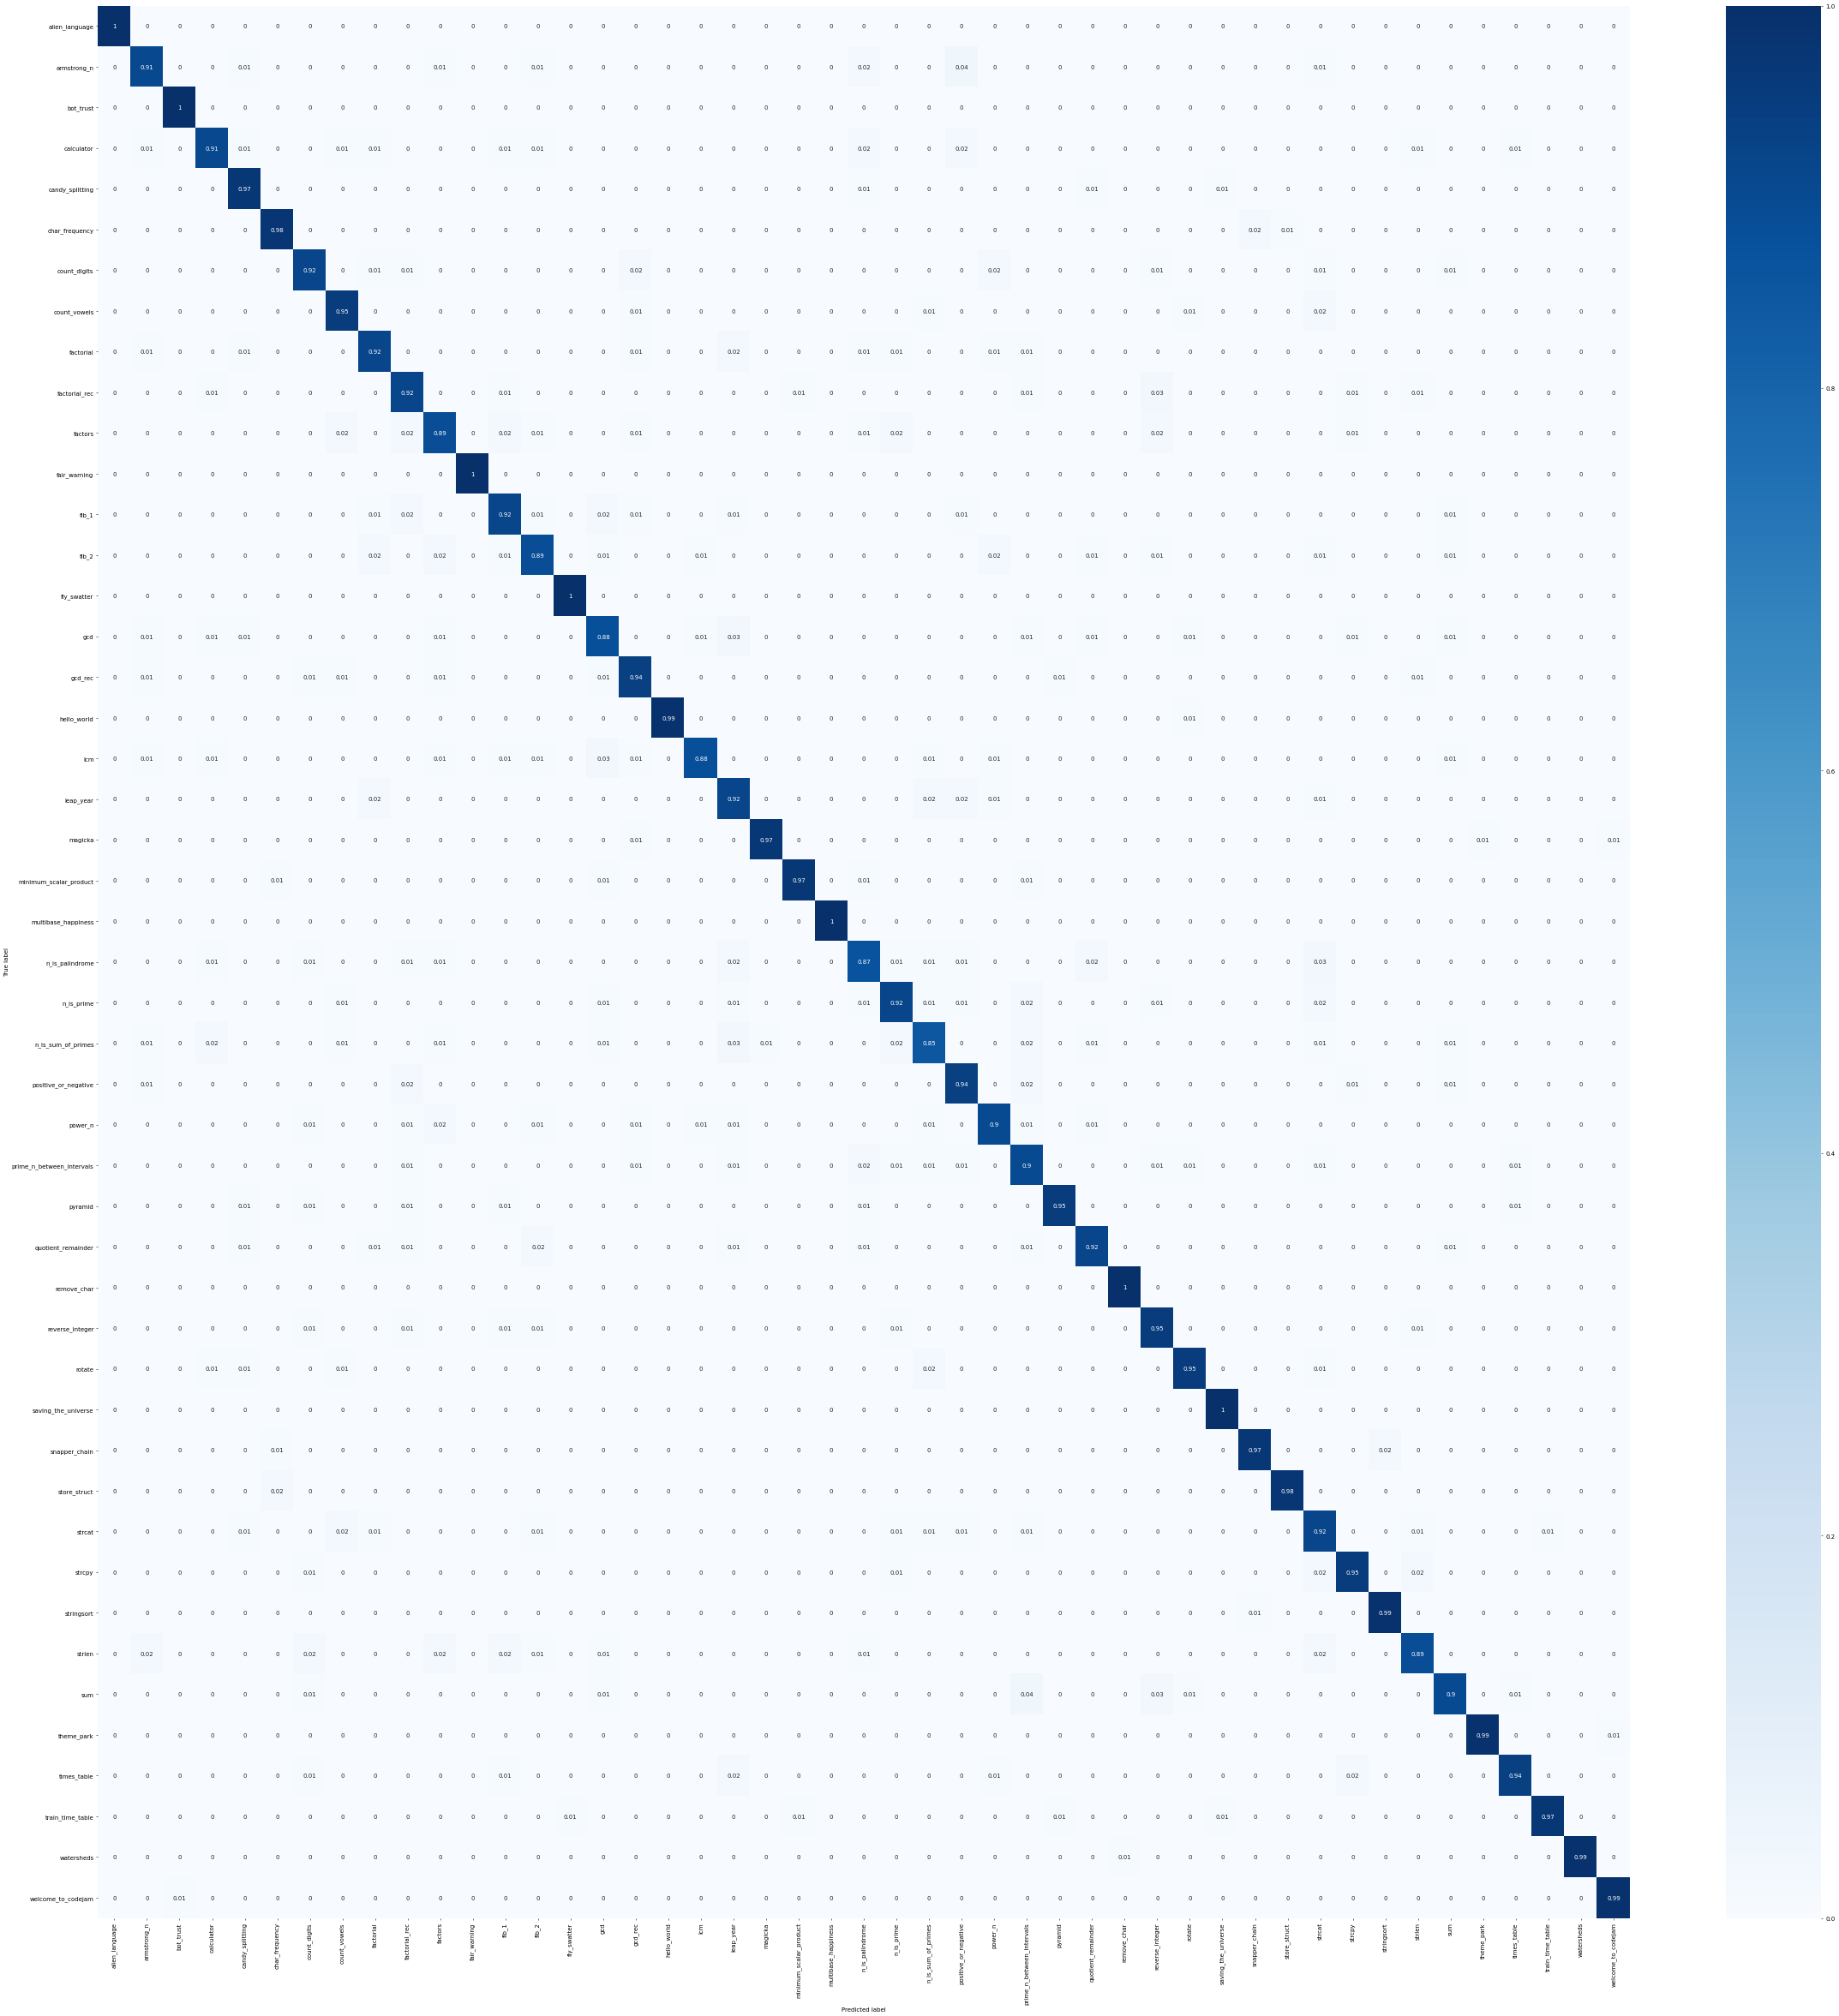

In [36]:
plt.show(my_lib.plot_conf_matrix(modelLSTM, validation_images, validation_labels_encoded, label_encoder))

Grafo degli errori focalizzato sul singolo set di offuscamento


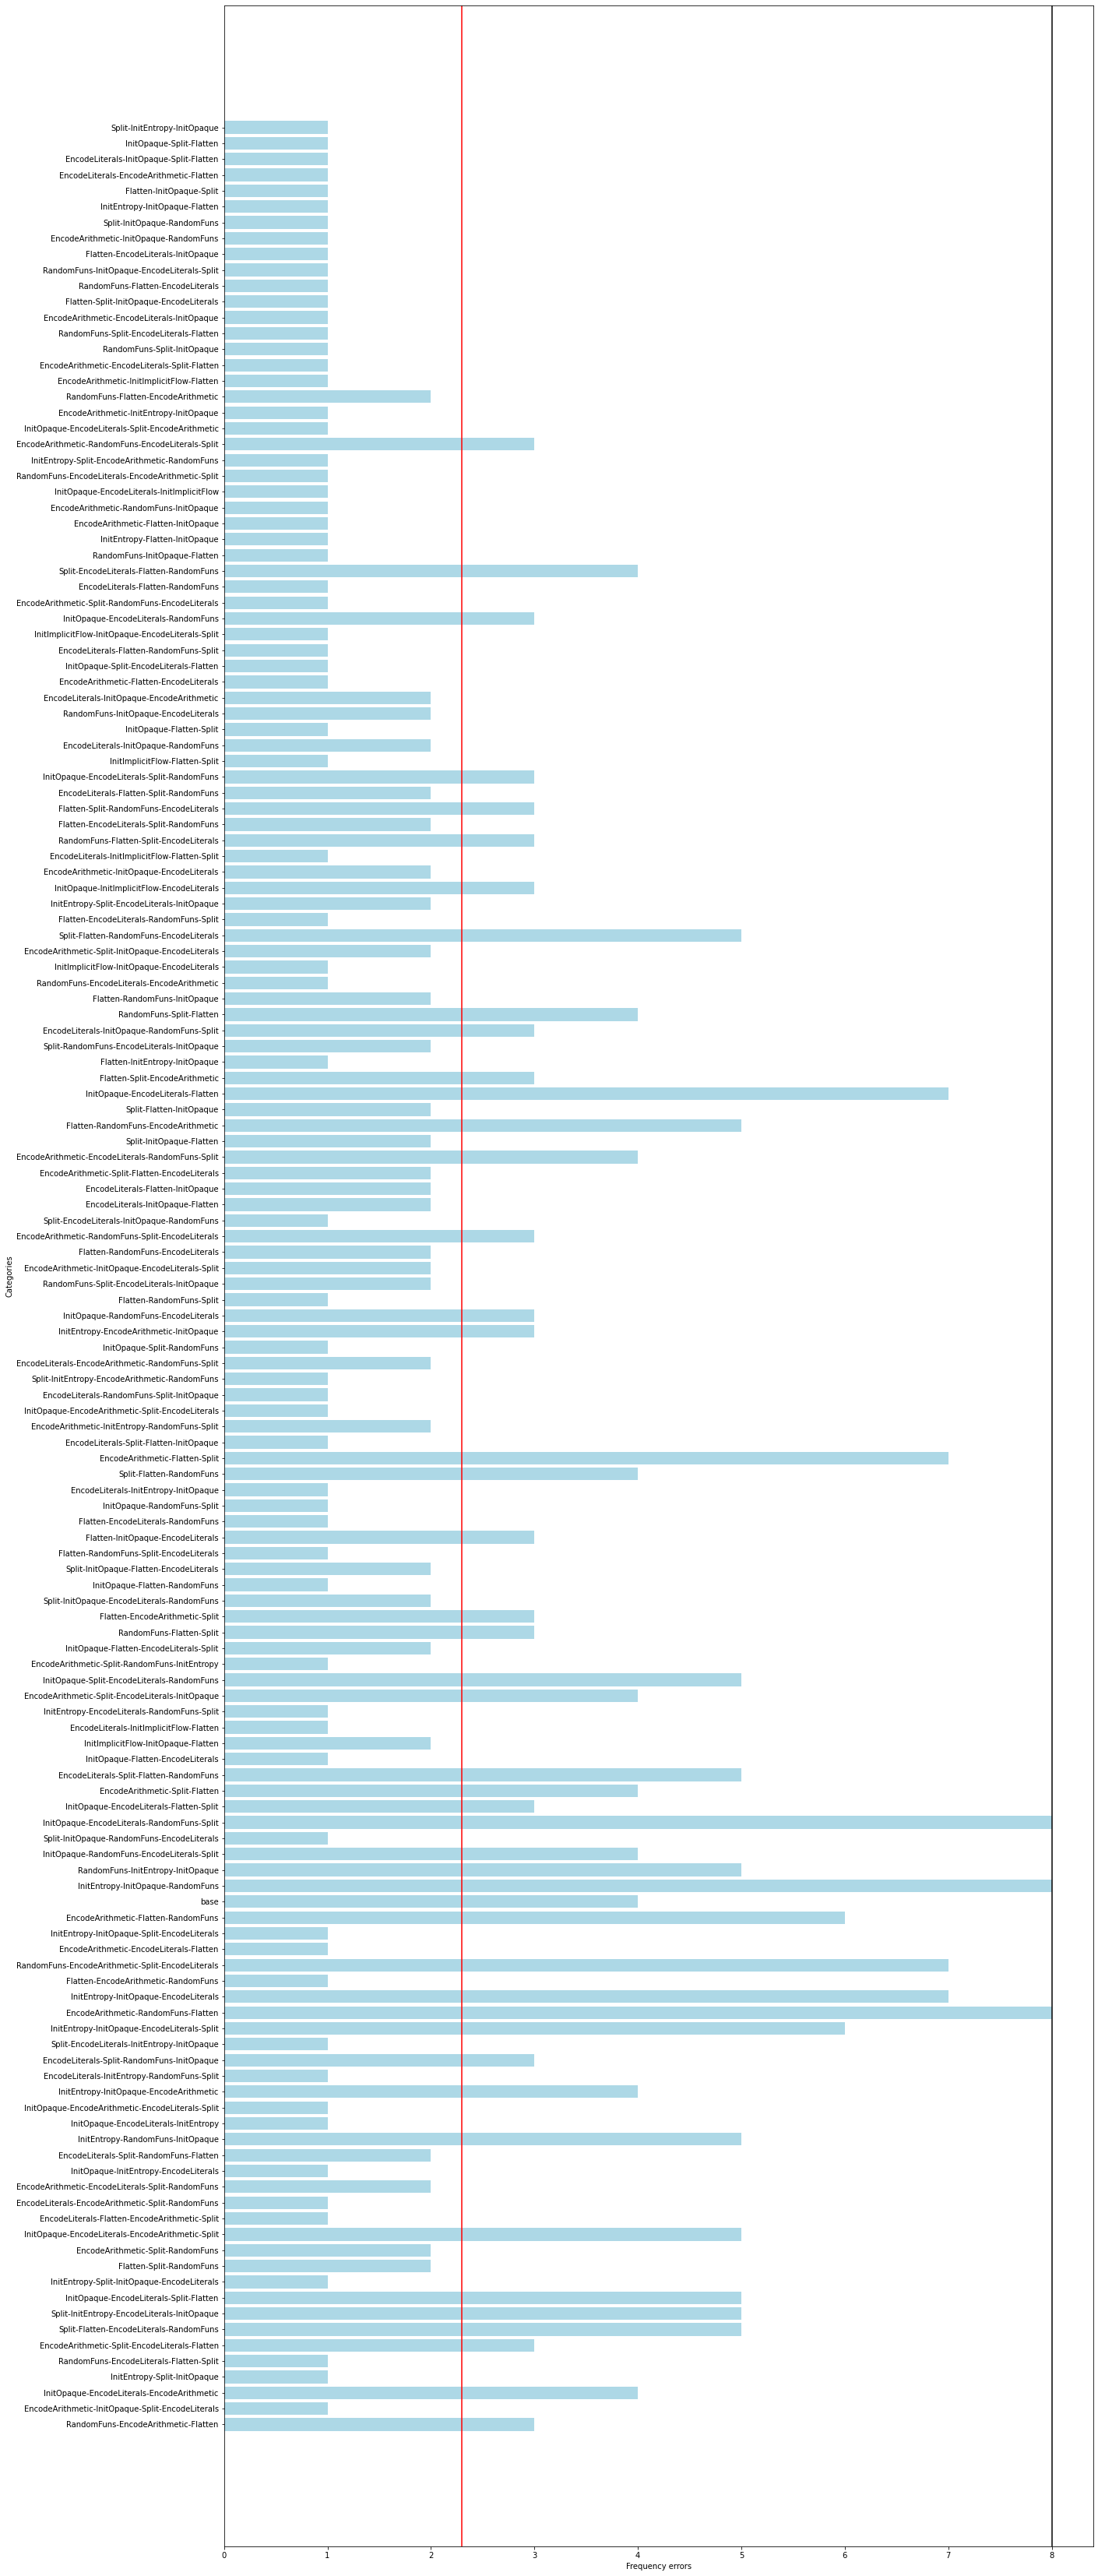


Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione


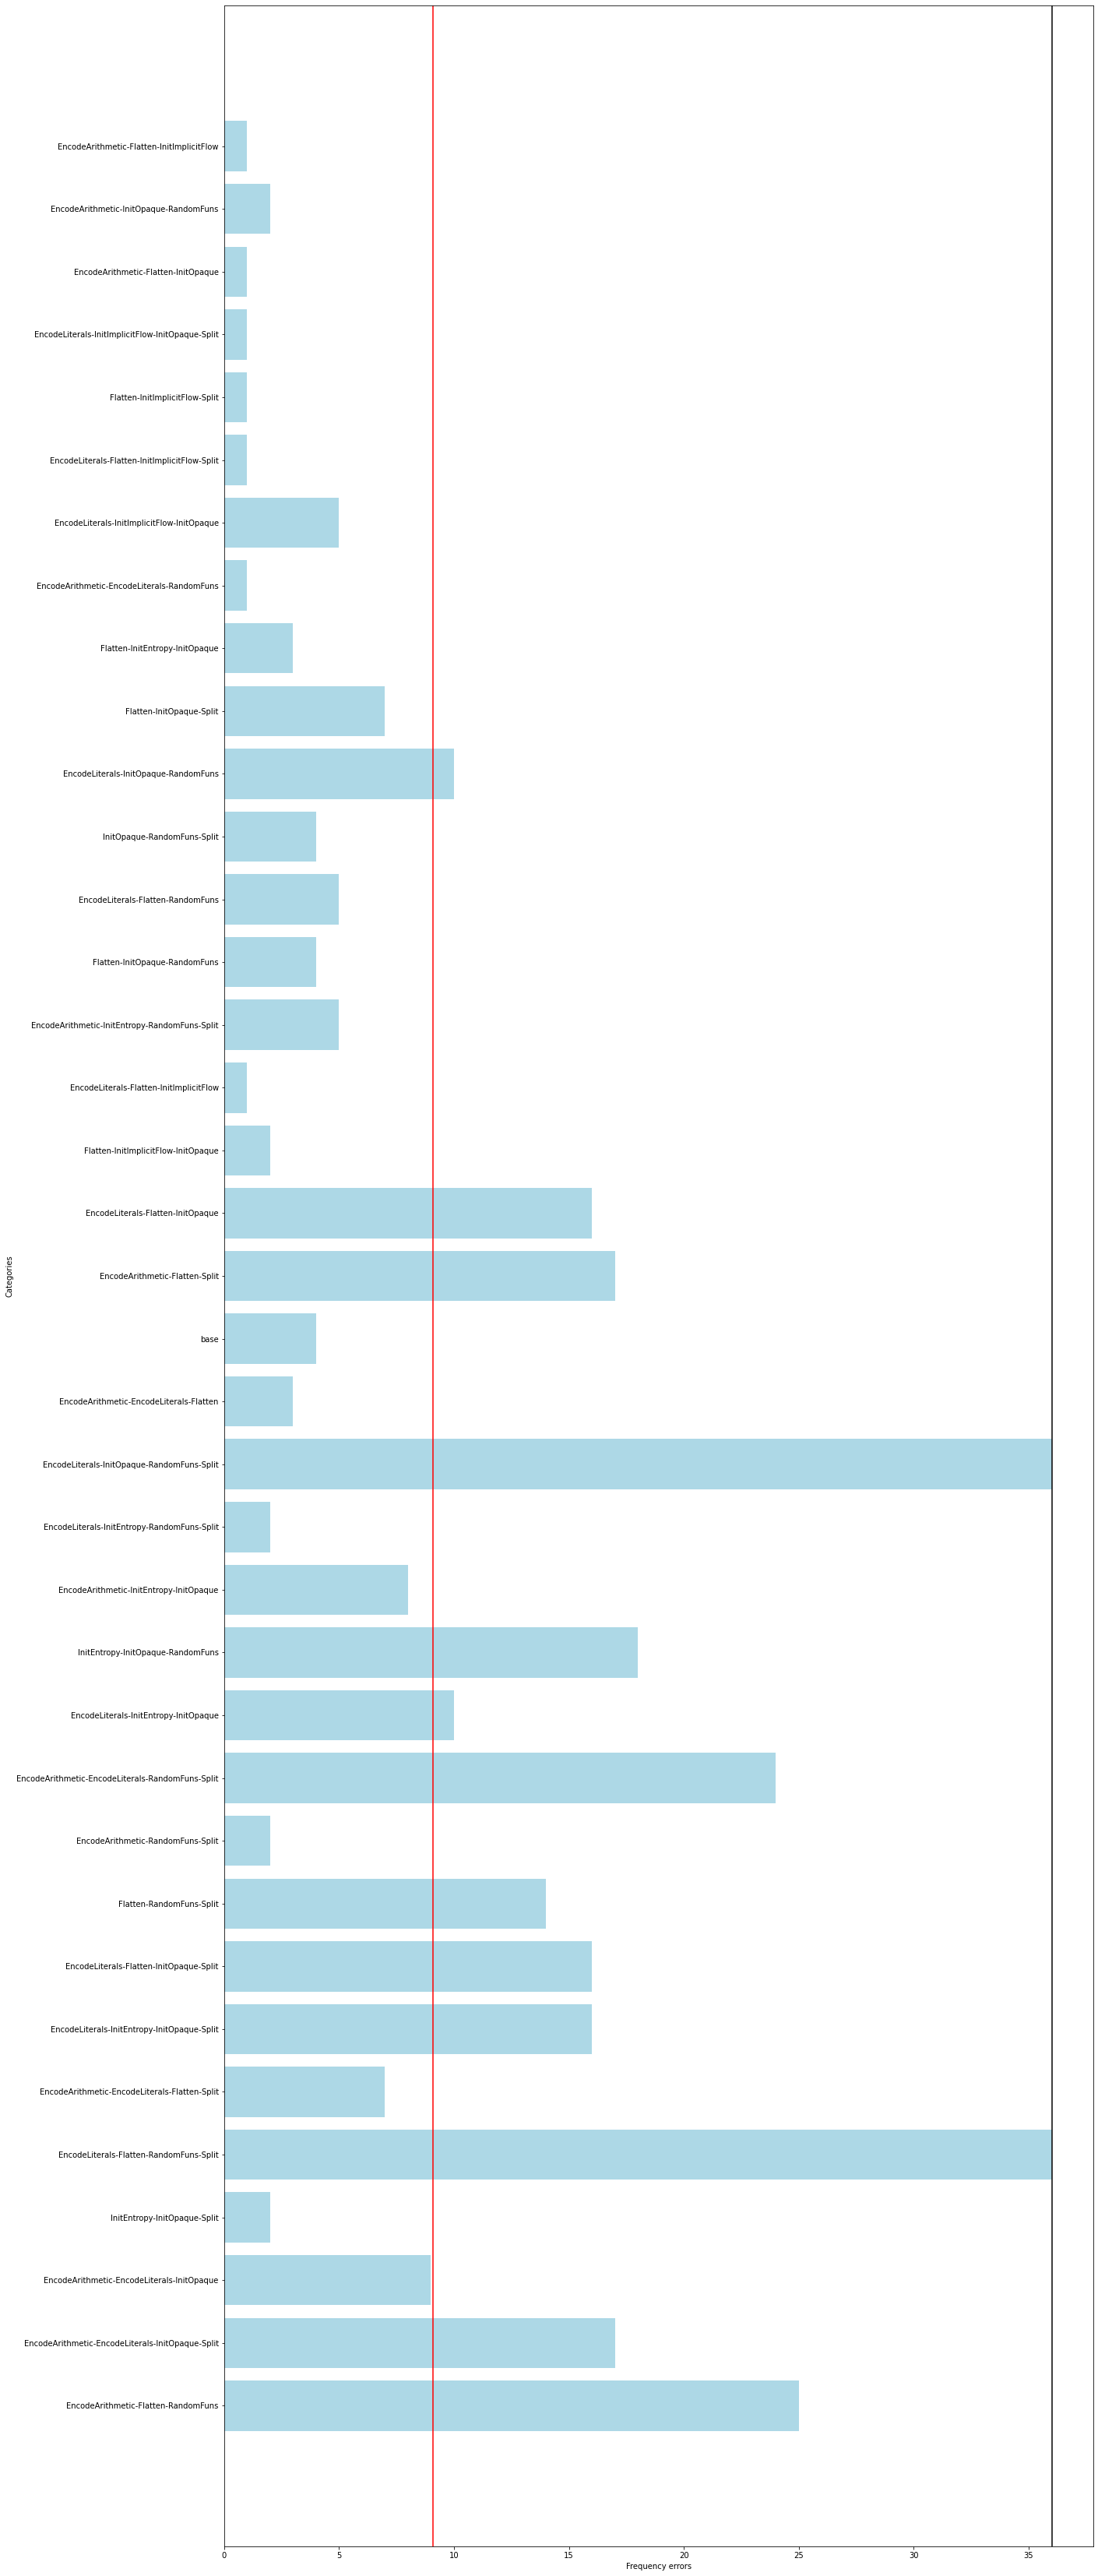


Grafo degli errori per classe


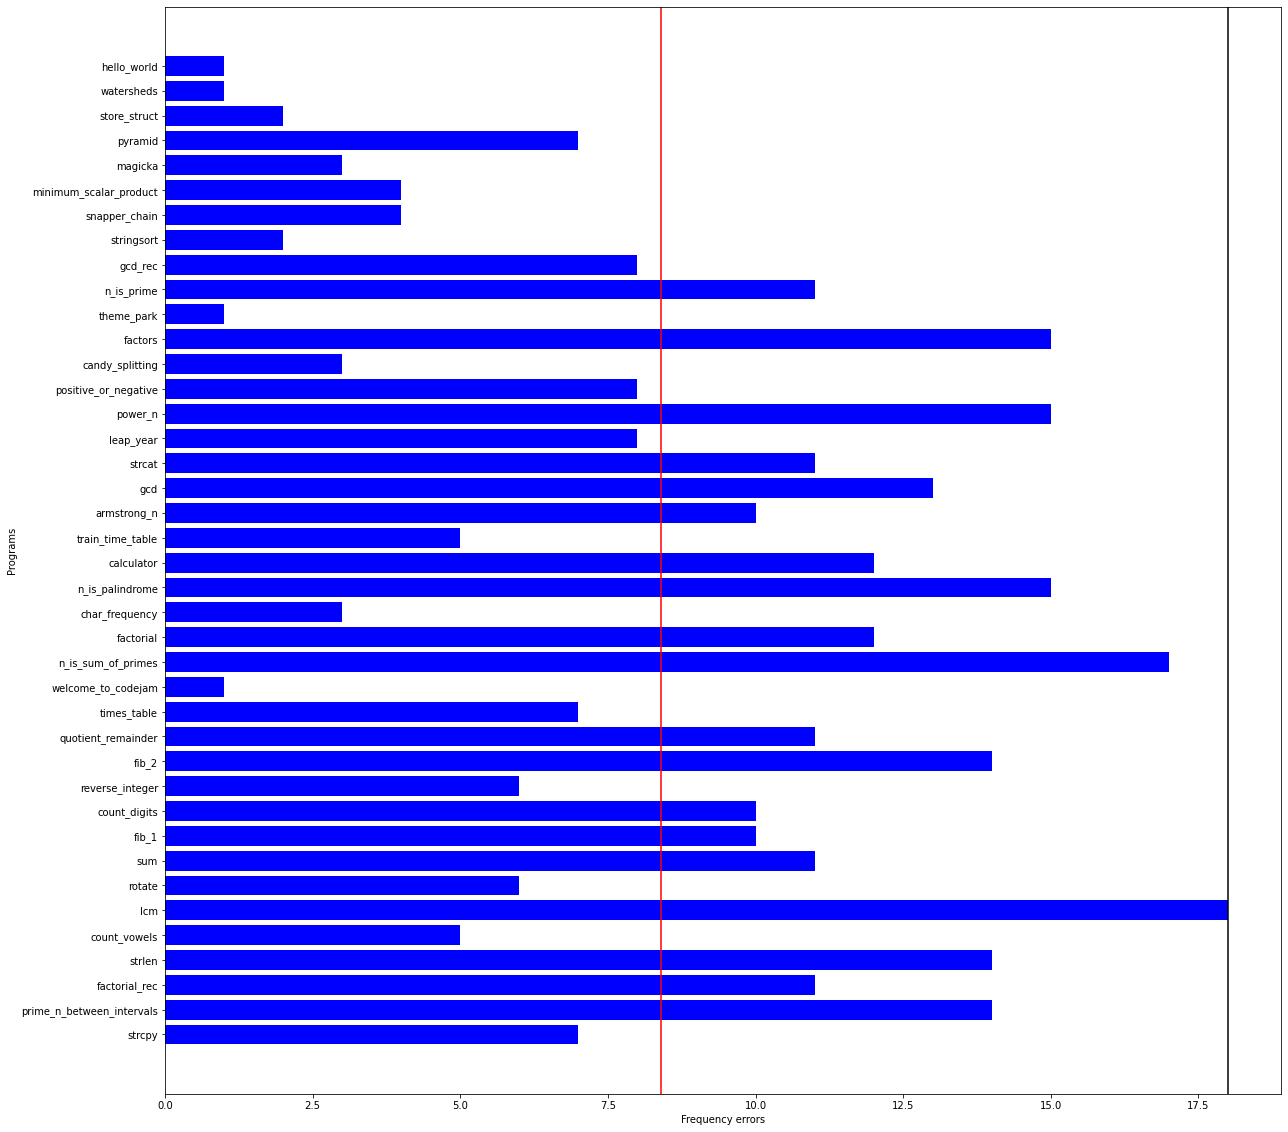


Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero


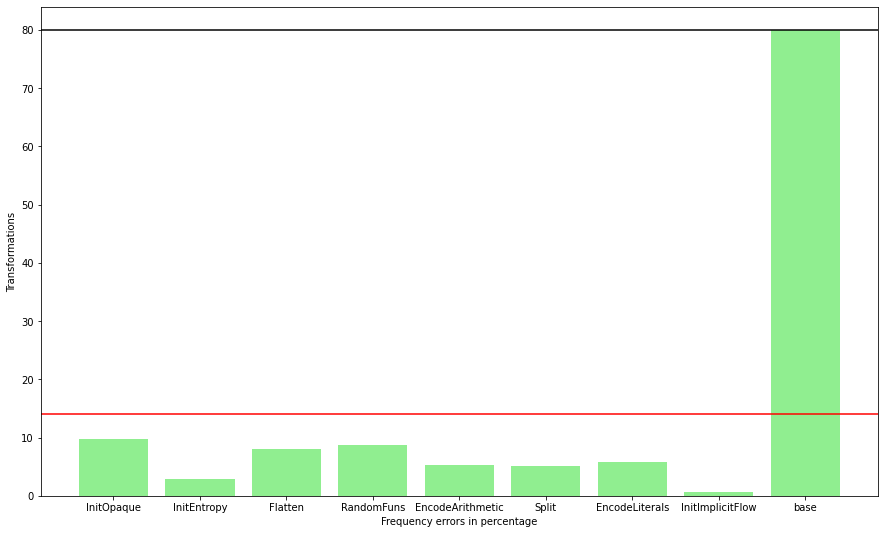

In [38]:
count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM, validation_images, validation_labels_encoded, validation_obf, label_encoder)

print("Grafo degli errori focalizzato sul singolo set di offuscamento")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori focalizzato su un set di offuscamenti, qualsiasi sia il loro ordine d'applicazione")
plt.show(my_lib.stampa_grafo_verticale(count_ordered_wr_obfs, 20, 60, "Frequency errors", "Categories", "lightblue"))
print()
print("Grafo degli errori per classe")
plt.show(my_lib.stampa_grafo_verticale(count_wrong_classes, 20, 20, "Frequency errors", "Programs", "blue"))
print()
print("Grafo degli errori di ogni singola trasformazione, in percentuale al loro numero")
plt.show(my_lib.stampa_grafo_orizzontale(single_wr_obf_percentage, 15, 9, "Frequency errors in percentage", "Transformations", "lightgreen"))


In [39]:
#Ordina e ritorna una lista
ordered_set_obfs = count_ordered_wr_obfs.most_common()
for elem in ordered_set_obfs:
  print(elem)

('EncodeLiterals-Flatten-RandomFuns-Split', 36)
('EncodeLiterals-InitOpaque-RandomFuns-Split', 36)
('EncodeArithmetic-Flatten-RandomFuns', 25)
('EncodeArithmetic-EncodeLiterals-RandomFuns-Split', 24)
('InitEntropy-InitOpaque-RandomFuns', 18)
('EncodeArithmetic-EncodeLiterals-InitOpaque-Split', 17)
('EncodeArithmetic-Flatten-Split', 17)
('EncodeLiterals-InitEntropy-InitOpaque-Split', 16)
('EncodeLiterals-Flatten-InitOpaque-Split', 16)
('EncodeLiterals-Flatten-InitOpaque', 16)
('Flatten-RandomFuns-Split', 14)
('EncodeLiterals-InitEntropy-InitOpaque', 10)
('EncodeLiterals-InitOpaque-RandomFuns', 10)
('EncodeArithmetic-EncodeLiterals-InitOpaque', 9)
('EncodeArithmetic-InitEntropy-InitOpaque', 8)
('EncodeArithmetic-EncodeLiterals-Flatten-Split', 7)
('Flatten-InitOpaque-Split', 7)
('EncodeArithmetic-InitEntropy-RandomFuns-Split', 5)
('EncodeLiterals-Flatten-RandomFuns', 5)
('EncodeLiterals-InitImplicitFlow-InitOpaque', 5)
('base', 4)
('Flatten-InitOpaque-RandomFuns', 4)
('InitOpaque-RandomFu

In [42]:
ordered_completo = my_lib.order_dict_of_dict(completo)
print("Classi - percentuale su tutto test set; aggiunti i 0%")
my_lib.stampa_percent_classeXobf(ordered_completo)

Classi - percentuale su tutto test set; aggiunti i 0%
strcpy := Flatten: 16.13%; RandomFuns: 10.26%; InitOpaque: 6.98%; EncodeArithmetic: 4.92%; Split: 3.45%; EncodeLiterals: 2.6%; InitEntropy: 1.79%; base: 0%; InitImplicitFlow: 0%; 
prime_n_between_intervals := RandomFuns: 19.57%; EncodeArithmetic: 19.05%; InitOpaque: 14.58%; Split: 12.0%; EncodeLiterals: 11.36%; InitEntropy: 6.67%; Flatten: 6.52%; InitImplicitFlow: 2.04%; base: 0%; 
factorial_rec := Flatten: 16.67%; InitOpaque: 16.28%; RandomFuns: 11.32%; EncodeLiterals: 9.76%; Split: 8.05%; InitEntropy: 6.0%; EncodeArithmetic: 1.69%; base: 0%; InitImplicitFlow: 0%; 
strlen := InitOpaque: 24.32%; InitEntropy: 15.22%; RandomFuns: 13.46%; Flatten: 12.82%; EncodeLiterals: 10.98%; Split: 9.57%; EncodeArithmetic: 8.7%; base: 0%; InitImplicitFlow: 0%; 
count_vowels := Flatten: 14.29%; RandomFuns: 8.11%; EncodeLiterals: 5.63%; Split: 4.55%; EncodeArithmetic: 4.55%; InitOpaque: 2.63%; base: 0%; InitEntropy: 0%; InitImplicitFlow: 0%; 
lcm := 

In [ ]:
img = plt.show(my_lib.stampa_grafo_verticale(count_wrong_obf, 20, 60, "Frequency errors", "Categories", "lightblue"))
np.save('errori.pdf', img, cmap='jet')